In [1]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
from IPython.display import HTML, Math
import pandas as pd
from matplotlib import pyplot as plt
import traceback


def cov_to_inf(X, domain):
    """
    Converts covariance form to influence diagram form

    Parameters:
    X (numpy.ndarray): Gaussian distribution (covariance matrix)
    domain (int): the number of rows and columns of X (assuming X is square)

    Returns:
    B (numpy.ndarray): An n x n matrix of Gaussian influence diagram arc coefficients which is strictly upper triangular
    V (numpy.ndarray): An n x 1 matrix of Gaussian influence diagram conditional variances with non-negative entries (including inf)
    P (numpy.ndarray): The (Moore-Penrose generalized) inverse of X
    """

    P = np.zeros((domain, domain))
    V = np.zeros(domain)
    B = np.zeros((domain, domain))

    # Initialize first row
    B[0, 0] = 0
    V[0] = X[0, 0]

    if V[0] == 0 or V[0] == np.inf:
        P[0, 0] = 0
    else:
        P[0, 0] = 1 / V[0]

    # Iterate through the domain
    for j in range(1, domain):
        B[j, j] = 0
        B[j, :j] = 0
        B[:j, j] = P[:j, :j].dot(X[:j, j])

        if X[j, j] == np.inf:
            V[j] = np.inf
        else:
            V[j] = X[j, j] - np.dot(X[j, :j], B[:j, j])
            V[j] = max(V[j], 0)

        if V[j] == 0 or V[j] == np.inf:
            P[j, j] = 0
            P[j, :j] = 0
            P[:j, j] = 0
        else:
            P[j, j] = 1 / V[j]
            for k in range(j):
                temp = P[j, j] * B[k, j]
                if k != 0:
                    P[k, :k] += temp * B[:k, j]
                    P[:k, k] = P[k, :k]
                P[k, k] += temp * B[k, j]
            P[j, :j] = -P[j, j] * B[:j, j]
            P[:j, j] = P[j, :j]

    return B, V.reshape(-1, 1), P


def get_Kalman(B, n, j):

    K = np.zeros(n)
    # First initialize the first element
    K[0] = B[n + j, 0]

    # Then, recursively calculate each row of K
    for n_idx in range(1, n):
        # Direct term
        direct_term = B[n + j, n_idx]

        # Summation term
        summation_term = 0
        for i in range(n_idx):  # Summation from 1 to n-1 (n_idx, r_idx are zero-based)
            summation_term += K[i] * B[i, n_idx]

        # Compute K[n, r]
        K[n_idx] = direct_term + summation_term

    return K


def evidence(u, B, V, X1, n0, n1, n2, du):
    """
    Enter evidence in influence diagram.

    Parameters:
    u (numpy.ndarray): A matrix with values including the mean of the state X(k) at discrete time k and the product of this mean and measurement matrix at discrete time k that maps the state X(k).
    B (numpy.ndarray): Matrix composed of covariance matrix of state X(k) and the measurement matrix at discrete time k.
    V (numpy.ndarray): A vector combining conditional variances with entries that are non-negative (including inf) and the measurement noise values.
    X1 (numpy.ndarray): Vector of n1 values with evidence in multivariate Gaussian with Influence Diagram form.
    n0 (int): Size of X0, where X0 is the predecessor of X1.
    n1 (int): Size of X1.
    n2 (int): Size of X2, where X2 is the successor of X1.
    du (numpy.ndarray): The change in u caused by the observed variable.

    Returns:
    u (numpy.ndarray): The updated mean vector of the state X(k) changed by the effect of the observed variable.
    B (numpy.ndarray): The updated matrix with strictly upper triangular submatrices and observed values set to 0.
    V (numpy.ndarray): The updated vector with non-negative entries (including inf) with the observed value set to 0.
    """

    K = np.zeros((n0, n1))
    for j in range(n1):
        B, V = reversal(B, V, 0, n0 + j, 1, n1 - j + n2)

        du[n0 + j] = X1[j] - u[n0 + j]
        du[:n0] = du[n0 + j] * B[n0 + j, :n0]

        if n0 + n1 + n2 >= n0 + j + 1:
            du[n0 + j + 1 : n0 + n1 + n2] = (
                du[n0 + j] * B[n0 + j, n0 + j + 1 : n0 + n1 + n2]
            )

        if n0 >= 2:
            for k in range(1, n0):  # Adjusting for 0-indexing in Python
                du[k] += np.dot(B[:k, k], du[:k])

        u[:n0] += du[:n0]

        if n1 + n2 >= j + 1:
            for k in range(n0 + j + 1, n0 + n1 + n2):
                du[k] += np.dot(B[:n0, k], du[:n0])
                du[k] += np.dot(
                    B[n0 + j + 1 : n0 + n1 + n2, k], du[n0 + j + 1 : n0 + n1 + n2]
                )
                u[k] += du[k]

        K_col = get_Kalman(B, n0, j)
        K[:, j] = K_col
        u[n0 + j] = 0
        V[n0 + j] = 0
        B[n0 + j, : n0 + n1 + n2] = 0

    return u, B, V, K


class trackingKF:
    def __init__(self, F, H, state, state_covariance, process_noise):
        self.StateTransitionModel = F
        self.MeasurementModel = H
        self.State = state
        self.StateCovariance = state_covariance
        self.ProcessNoise = process_noise


# Define the IDcorrect function as previously provided
def id_correct(filter, zmeas, zcov):
    u = filter.State
    P = filter.StateCovariance
    H = filter.MeasurementModel
    F = filter.StateTransitionModel
    Qk = filter.ProcessNoise
    M = Qk.shape
    Vzeros = np.zeros((M[0], 1))
    I = np.eye(M[0])

    # Perform measurement update
    u, V, B, K = mupdate(0, zmeas, u, P, Vzeros, zcov, H)

    # Get the shape of B and set up L
    col_L, row_L = B.shape
    L = col_L
    B = inf_to_cov(V, B, L)

    # Set corrected values
    xcorr = u
    Pcorr = B

    return xcorr, Pcorr


def id_predict(filter):
    """
    Performs the Time Update (prediction) portion of the Kalman Filter for object-oriented programming.

    Parameters:
    filter (object): A trackingKF object that contains State, StateCovariance, MeasurementModel, StateTransitionModel, and ProcessNoise.

    Returns:
    xpred (numpy.ndarray): The predicted state.
    Ppred (numpy.ndarray): The predicted state estimation error covariance.
    """

    # Extract filter parameters
    u = filter.State
    B_old = filter.StateCovariance
    H = filter.MeasurementModel
    F = filter.StateTransitionModel
    Qk = filter.ProcessNoise

    M = Qk.shape[0]
    I = np.eye(M)

    # Convert covariance to influence diagram form
    B_old, V_old, Precision = cov_to_inf(B_old, M)

    # Perform time update
    u, B, V = tupdate(u, B_old, V_old, F, I, Qk)

    # Convert influence diagram back to covariance form
    Ppred = inf_to_cov(V, B, M)

    xpred = u

    return xpred, Ppred


def inf_to_cov(V, B, domain):
    """
    Converts influence diagram form to covariance form.

    Parameters:
    V (numpy.ndarray): An n x 1 vector with non-negative (including inf) entries.
    B (numpy.ndarray): An n x n matrix that is strictly upper triangular.
    domain (int): The number of rows and columns of B.

    Returns:
    X (numpy.ndarray): The covariance matrix of the multivariate Gaussian distribution.
    """

    # Initialize the covariance matrix X
    X = np.zeros((domain, domain))

    # First element in the diagonal
    X[0, 0] = V[0]

    for i in range(1, domain):
        for j in range(i):
            X[i, j] = 0
            for k in range(i):
                if X[j, k] != np.inf:
                    X[i, j] += X[j, k] * B[k, i]
            X[j, i] = X[i, j]  # Since the matrix is symmetric

        # Update diagonal elements
        if V[i] == np.inf:
            X[i, i] = np.inf
        else:
            Y = X[i, :i]
            Z = B[:i, i]
            X[i, i] = V[i] + np.dot(Y, Z)

    return X


def kalman(k, Z, u, X, V, R, H, Phi, gamma, Qk, Form, h=None):
    """
    Apply Kalman filter at time k.

    Parameters:
    k (int): Desired discrete time.
    Z (numpy.ndarray): Measurement values at discrete time k.
    u (numpy.ndarray): An n x 1 vector representing the mean of the state at time k.
    X (numpy.ndarray): If k=0, the covariance matrix of state at time k. If k≠0, the matrix of Gaussian influence diagram arc coefficients.
    V (numpy.ndarray): If k≠0, an n x 1 vector of Gaussian influence diagram conditional variances. Ignored if k=0.
    R (numpy.ndarray): The measurement noise covariance matrix R.
    H (numpy.ndarray): The measurement matrix at discrete time k.
    Phi (numpy.ndarray): The state transition matrix at time k.
    gamma (numpy.ndarray): The process noise matrix at time k.
    Qk (numpy.ndarray): The process noise covariance matrix.
    Form (int): Determines the output form (0 for ID form, 1 for covariance form).

    Returns:
    u (numpy.ndarray): The updated mean vector.
    B (numpy.ndarray): The updated state covariance matrix or influence diagram form matrix.
    V (numpy.ndarray): The updated vector of conditional variances.
    """

    # Get dimensions
    domain = X.shape[0]
    p = Z.shape[0]

    # Perform measurement update
    u, V, B, K = mupdate(k, Z, u, X, V, R, H, h)
    u_new = u[:domain]
    V_new = V[:domain]
    B_new = B[:domain, :domain]

    # Perform time update
    u, B, V = tupdate(u_new, B_new, V_new, Phi, gamma, Qk)

    # Convert back to covariance form if required
    if Form == 1:
        B = inf_to_cov(V, B, domain)

    return u, B, V


def mupdate(k, Z, u, B_or_sigma, V, R, H, h=None):
    """
    Mupdate
    Measurement update for measurement Z(k)

    Inputs:
    k - desired discrete time
    Z - p x 1 vector of measurement values at discrete time k
    u - n x 1 vector that represents the mean of the state X(k) at discrete time k
    B_or_sigma - If k == 0, n x n covariance matrix of state X(k) at discrete time k.
                 If k != 0, n x n matrix of Gaussian influence diagram arc coefficients of state X(k).
    V - If k != 0, n x 1 vector of Gaussian influence diagram conditional variances.
        If k == 0, this input is ignored.
    R - p x p diagonal measurement noise covariance matrix R
    H - p x n measurement matrix at discrete time k

    Outputs:
    u - updated n x 1 vector representing the mean of the state X(k+1)
    V - updated n x 1 vector of Gaussian influence diagram conditional variances of state X(k+1)
    B - updated n x n matrix of Gaussian influence diagram arc coefficients of state X(k+1)
    """

    # Determine dimensions of V and Z
    domain = V.shape[0]
    n = domain
    p = Z.shape[0]

    if k == 0:
        B, V, P = cov_to_inf(B_or_sigma, domain)

    # Prepare intermediate values for update
    X1 = np.array(Z).reshape(-1, 1)
    n0 = n
    n1 = p
    n2 = 0
    u_new = np.vstack((u, H @ u))
    if h is not None:
        u_new = np.vstack((u, h))

    # Construct V_new to match MATLAB structure
    V_new = np.vstack((V, np.diag(R).reshape(-1, 1)))

    # Build the B_new matrix
    Opn = np.zeros((p, n))
    Opp = np.zeros((p, p))
    B_new = np.block([[B, H.T], [Opn, Opp]])

    V_new = V_new.T
    V_new = V_new.flatten()
    u_new = u_new.T
    u_new = u_new.flatten()
    X1 = X1.T
    X1 = X1.flatten()
    du = u_new.copy()

    # Update using Evidence function
    u, B, V, K = evidence(u_new, B_new, V_new, X1, n0, n1, n2, du)


    # Return only the relevant portions
    u = u[:n]
    B = B[:n, :n]
    V = V[:n]

    return u, V, B, K


def removal(B, V, n0, n1, n2):
    """
    Removal of vector nodes in Gaussian influence diagram.

    Parameters:
    B (numpy.ndarray): An n x n strictly upper triangular matrix comprised of strictly upper triangular submatrices.
    V (numpy.ndarray): An n x 1 vector with non-negative (including inf) entries.
    n0 (int): The size of vector node x0.
    n1 (int): The size of vector node x1.
    n2 (int): The size of vector node x2.

    Returns:
    B (numpy.ndarray): Updated n x n matrix with removed vector nodes.
    V (numpy.ndarray): Updated n x 1 vector with removed vector nodes.
    """

    # If n2 > 1, reverse arcs from vector node x1 to the first n2-1 elements of vector node x2
    if n2 > 1:
        B, V = reversal(B, V, n0, n1, n2 - 1, 0)

    N = n0 + n1 + n2

    # Iteratively remove elements of the vector nodes
    for i in range(n0 + n1, n0, -1):
        if n0 >= 1:
            B[:n0, N - 1] += B[i - 1, N - 1] * B[:n0, i - 1]

        if i - 1 > n0:
            B[n0 : i - 1, N - 1] += B[i - 1, N - 1] * B[n0 : i - 1, i - 1]

        if N - 1 > n0 + n1:
            B[n0 + n1 : N - 1, N - 1] += B[i - 1, N - 1] * B[n0 + n1 : N - 1, i - 1]

        if V[i - 1] != 0:
            # Check for infinity before updating V[N-1]
            if V[i - 1] != np.inf and V[N - 1] != np.inf:
                V[N - 1] += B[i - 1, N - 1] * B[i - 1, N - 1] * V[i - 1]
            else:
                V[N - 1] = np.inf

    # Set appropriate entries in V and B to 0 after removing node x1
    V[n0 : n0 + n1] = 0
    B[n0 : n0 + n1, :] = 0
    B[:, n0 : n0 + n1] = 0

    return B, V


def reversal(B, V, n0, n1, n2, n3):
    """
    Arc reversal between two nodes using Bayes' rule.

    Parameters:
    B (numpy.ndarray): An n x n strictly upper triangular matrix, composed of strictly upper triangular submatrices.
    V (numpy.ndarray): An n x 1 vector with non-negative (including inf) entries.
    n0 (int): Size of vector node x0.
    n1 (int): Size of vector node x1.
    n2 (int): Size of vector node x2.
    n3 (int): Size of vector node x3.

    Returns:
    B (numpy.ndarray): Updated matrix with reversed arcs.
    V (numpy.ndarray): Updated vector with adjusted variances.
    """

    # Iterate from n0 + n1 down to n0 + 1
    for i in range(n0 + n1, n0, -1):
        for j in range(n0 + n1 + 1, n0 + n1 + n2 + 1):
            if B[i - 1, j - 1] != 0:
                # Update the matrix B by adjusting the appropriate elements
                if n0 >= 1:
                    B[:n0, j - 1] += B[i - 1, j - 1] * B[:n0, i - 1]

                if i - 1 > n0:
                    B[n0 : i - 1, j - 1] += B[i - 1, j - 1] * B[n0 : i - 1, i - 1]

                if j - 1 > n0 + n1:
                    B[n0 + n1 : j - 1, j - 1] += (
                        B[i - 1, j - 1] * B[n0 + n1 : j - 1, i - 1]
                    )

                # Update based on the variance matrix V
                if V[i - 1] == 0:
                    B[j - 1, i - 1] = 0
                else:
                    if V[i - 1] != np.inf and V[j - 1] != np.inf:
                        if V[j - 1] == 0:
                            V[j - 1] = B[i - 1, j - 1] ** 2 * V[i - 1]
                            V[i - 1] = 0
                            B[j - 1, i - 1] = 1 / B[i - 1, j - 1]
                        else:
                            Vj_old = V[j - 1]
                            V[j - 1] += B[i - 1, j - 1] ** 2 * V[i - 1]
                            V_ratio = V[i - 1] / V[j - 1]
                            V[i - 1] = Vj_old * V_ratio
                            B[j - 1, i - 1] = B[i - 1, j - 1] * V_ratio
                    else:
                        if V[j - 1] != np.inf:
                            B[j - 1, i - 1] = 1 / B[i - 1, j - 1]
                        else:
                            B[j - 1, i - 1] = 0

                        if V[i - 1] == np.inf and V[j - 1] != np.inf:
                            V[i - 1] = V[j - 1] * B[j - 1, i - 1] ** 2

                        V[j - 1] = np.inf

                # Zero out the current entry
                B[i - 1, j - 1] = 0

                # Further update B based on the reversal process
                if n0 >= 1:
                    B[:n0, i - 1] -= B[j - 1, i - 1] * B[:n0, j - 1]

                if i - 1 > n0:
                    B[n0 : i - 1, i - 1] -= B[j - 1, i - 1] * B[n0 : i - 1, j - 1]

                if j - 1 > n0 + n1:
                    B[n0 + n1 : j - 1, i - 1] -= (
                        B[j - 1, i - 1] * B[n0 + n1 : j - 1, j - 1]
                    )

    return B, V


def tupdate(u, B, V, Phi, gamma, Qk):
    """
    Time update from X(k) to X(k+1) in the Kalman filter.

    Parameters:
    u (numpy.ndarray): An n x 1 vector representing the mean of the state X(k) at time k.
    B (numpy.ndarray): An n x n matrix of Gaussian influence diagram arc coefficients of state X(k) at time k.
    V (numpy.ndarray): An n x 1 vector of Gaussian influence diagram conditional variances of state X(k).
    Phi (numpy.ndarray): The n x n state transition matrix Phi(k).
    gamma (numpy.ndarray): The n x r process noise matrix Gamma(k).
    Qk (numpy.ndarray): The r x r process noise covariance matrix of the process noise vector w(k).

    Returns:
    u (numpy.ndarray): The updated mean vector of the state X(k+1) at time k+1.
    B (numpy.ndarray): The updated matrix of Gaussian influence diagram arc coefficients of state X(k+1).
    V (numpy.ndarray): The updated vector of conditional variances of state X(k+1).
    """

    # Get dimensions
    n = u.shape[0]  # size of u
    r = Qk.shape[0]  # size of Qk

    # Convert process noise covariance matrix to influence diagram form
    Bq, Vq, _ = cov_to_inf(Qk, r)

    # Prepare block matrices
    On = np.zeros((n, n))
    Or = np.zeros((r, r))
    Onr = np.zeros((n, r))
    On1 = np.zeros((n, 1))
    Or1 = np.zeros((r, 1))

    # Create new V and B matrices for the update
    V_new = np.concatenate((Vq.reshape(-1, 1), V.reshape(-1, 1), On1), axis=0)
    B_new = np.block([[Bq, Onr.T, gamma.T], [Onr, B, Phi.T], [Onr, On, On]])

    # Perform Removal operation to update B and V
    n0 = 0
    n1 = r
    n2 = n + n

    B_temp, V_temp = removal(B_new, V_new, n0, n1, n2)

    n0 = r
    n1 = n
    n2 = n

    V_temp = V_temp.flatten()
    B, V = removal(B_temp, V_temp, n0, n1, n2)

    # Update V and B for the current step
    V = V.flatten()  # Ensure V is a flat vector
    B = B[n + r : n + r + n, n + r : n + r + n]  # Extract the relevant part of B
    V = V[n + r : n + r + n]  # Extract the relevant part of V

    # Update the mean vector
    u_new = Phi @ u  # Update u using the state transition matrix
    u = u_new

    return u, B, V



# ---------------------------------
# Create Matrix Input
# ---------------------------------
def create_matrix_input(description, default_values, rows, cols):
    """
    Create a dynamic grid of FloatText widgets with given default values.

    Parameters
    ----------
    description : str
        Label for the matrix.
    default_values : np.ndarray
        Default NumPy array of values.
    rows : int
        Initial number of rows.
    cols : int
        Initial number of columns.

    Returns
    -------
    container : widgets.VBox
        A VBox containing the entire matrix input UI.
    matrix_grid : widgets.GridBox
        GridBox containing the individual FloatText widgets.
    """
    matrix_label = widgets.HTML(
        f"<b>{description}</b>", layout=widgets.Layout(margin="0 0 5px 0")
    )
    matrix_grid = widgets.GridBox(
        children=[
            widgets.FloatText(
                value=(
                    default_values[i, j]
                    if i < default_values.shape[0] and j < default_values.shape[1]
                    else 0.0
                ),
                layout=widgets.Layout(width="70px"),
            )
            for i in range(rows)
            for j in range(cols)
        ],
        layout=widgets.Layout(grid_template_columns=f"repeat({cols}, 80px)"),
    )
    container = widgets.VBox([matrix_label, matrix_grid])
    return container, matrix_grid

# ---------------------------------
# Create Dynamic Matrices
# ---------------------------------
def create_dynamic_matrices(n, p, r):
    """
    Create matrices based on global dimensions n, p, and r.

    Parameters
    ----------
    n : int
        State size.
    p : int
        Measurement size.
    r : int
        Noise size.

    Returns
    -------
    tuple
        Accordion widget and individual GridBoxes for the matrices.
    """
    
    # ---------------------------------
    # Default Values
    # ---------------------------------
    Z_default = np.array([[502.55], [-0.9316]])
    u_default = np.array([[400], [0], [0], [-300], [0], [0]])
    X_default = np.array(
        [
        [1125, 750, 250, 0, 0, 0],
        [750, 1000, 500, 0, 0, 0],
        [250, 500, 500, 0, 0, 0],
        [0, 0, 0, 1125, 750, 250],
        [0, 0, 0, 750, 1000, 500],
        [0, 0, 0, 250, 500, 500],
        ]
    )
    V_default = np.zeros((6, 1))
    R_default = np.array([[25, 0], [0, 0.0087**2]])
    H_default = np.array([[0.8, 0, 0, -0.6, 0, 0], [0.0012, 0, 0, 0.0016, 0, 0]])
    Phi_default = np.array([
        [1, 1, 0.5, 0, 0, 0],
        [0, 1, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 1, 0.5],
        [0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 1],
    ])
    gamma_default = np.eye(6)
    Qk_default = np.array([
        [0.25, 0.5, 0.5, 0, 0, 0],
        [0.5, 1, 1, 0, 0, 0],
        [0.5, 1, 1, 0, 0, 0],
        [0, 0, 0, 0.25, 0.5, 0.5],
        [0, 0, 0, 0.5, 1, 1],
        [0, 0, 0, 0.5, 1, 1],
    ]) * (0.2**2)
    h_default = np.array([[500], [-0.644]])

    Z_input, Z_grid = create_matrix_input("Z (Measurement Values):", Z_default, p, 1)
    u_input, u_grid = create_matrix_input("u (State Mean Vector):", u_default, n, 1)
    X_input, X_grid = create_matrix_input("X (Covariance Matrix):", X_default, n, n)
    V_input, V_grid = create_matrix_input("V (Conditional Variances):", V_default, n, 1)
    R_input, R_grid = create_matrix_input("R (Measurement Noise Covariance):", R_default, p, p)
    H_input, H_grid = create_matrix_input("H (Measurement Matrix):", H_default, p, n)
    Phi_input, Phi_grid = create_matrix_input("Phi (State Transition Matrix):", Phi_default, n, n)
    gamma_input, gamma_grid = create_matrix_input("gamma (Process Noise Matrix):", gamma_default, n, r)
    Qk_input, Qk_grid = create_matrix_input("Qk (Process Noise Covariance):", Qk_default, r, r)
    h_input, h_grid = create_matrix_input("h (Expected Measurement Values):", h_default, p, 1)

    accordion = widgets.Accordion(
        children=[
            Z_input, u_input, X_input, V_input, R_input,
            H_input, Phi_input, gamma_input, Qk_input, h_input
        ],
        selected_index=None,
        layout=widgets.Layout(width="700px"),
    )
    accordion.set_title(0, "Z (Measurement Values)")
    accordion.set_title(1, "u (State Mean Vector)")
    accordion.set_title(2, "X (Covariance Matrix)")
    accordion.set_title(3, "V (Conditional Variances)")
    accordion.set_title(4, "R (Measurement Noise Covariance)")
    accordion.set_title(5, "H (Measurement Matrix)")
    accordion.set_title(6, "Phi (State Transition Matrix)")
    accordion.set_title(7, "gamma (Process Noise Matrix)")
    accordion.set_title(8, "Qk (Process Noise Covariance)")
    accordion.set_title(9, "h (Expected Measurement Values)")

    return accordion, Z_grid, u_grid, X_grid, V_grid, R_grid, H_grid, Phi_grid, gamma_grid, Qk_grid, h_grid

# ---------------------------------
# Dimension Controls
# ---------------------------------
dim_label = widgets.HTML("<b>Global Dimensions:</b>")
n_input = widgets.IntText(value=6, description="n (State Size):", layout=widgets.Layout(width="200px"), style={"description_width": "120px"})
p_input = widgets.IntText(value=2, description="p (Measurement Size):", layout=widgets.Layout(width="200px"), style={"description_width": "150px"})
r_input = widgets.IntText(value=6, description="r (Noise Size):", layout=widgets.Layout(width="200px"), style={"description_width": "150px"})
dim_update_button = widgets.Button(description="Update Dimensions", button_style="info", layout=widgets.Layout(width="150px"))
dimension_controls = widgets.HBox([n_input, p_input, r_input, dim_update_button])

# ---------------------------------
# Initialize Matrices
# ---------------------------------
accordion, Z_grid, u_grid, X_grid, V_grid, R_grid, H_grid, Phi_grid, gamma_grid, Qk_grid, h_grid = create_dynamic_matrices(6, 2, 6)

# ---------------------------------
# Update Dimensions Handler
# ---------------------------------
def update_dimensions(_):
    """
    Update all matrix dimensions based on global n, p, and r inputs.
    """
    n = n_input.value
    p = p_input.value
    r = r_input.value

    global accordion, Z_grid, u_grid, X_grid, V_grid, R_grid, H_grid, Phi_grid, gamma_grid, Qk_grid, h_grid
    accordion, Z_grid, u_grid, X_grid, V_grid, R_grid, H_grid, Phi_grid, gamma_grid, Qk_grid, h_grid = create_dynamic_matrices(n, p, r)

    # Update the UI
    final_layout.children = [dimension_controls, accordion, control_panel, output]

dim_update_button.on_click(update_dimensions)

# ---------------------------------
# Control Panel
# ---------------------------------
Form_input = widgets.Dropdown(
    options=["ID Form", "Covariance Form"],
    value="Covariance Form",
    description="Output in:",
    layout=widgets.Layout(width="250px"),
)
run_button = widgets.Button(
    description="Run Kalman Filter",
    button_style="success",
    layout=widgets.Layout(width="250px"),
)
control_panel = widgets.HBox([Form_input, run_button])
output = widgets.Output()

# ---------------------------------
# Function: parse_matrix
# ---------------------------------
def parse_matrix(grid, rows, cols, description):
    """
    Parse the values from a GridBox of FloatText widgets into a NumPy array.

    Parameters
    ----------
    grid : widgets.GridBox
        The grid containing FloatText widgets.
    rows : int
        Number of rows to reshape into.
    cols : int
        Number of columns to reshape into.
    description : str
        Descriptor for error messages.

    Returns
    -------
    np.ndarray
        Reshaped array with the parsed float values.

    Raises
    ------
    ValueError
        If any parsing/reshaping error occurs.
    """
    try:
        values = [float(child.value) for child in grid.children]
        return np.array(values).reshape(rows, cols)
    except Exception as e:
        raise ValueError(f"Error parsing {description}: {e}")

def parse_and_run_kalman():
    """
    Parse all matrices from the widgets and run the Kalman filter with the parsed inputs.
    """
    try:
        # Parse n, p, and r from the dimension controls
        n = n_input.value
        p = p_input.value
        r = r_input.value

        # Parse matrices from the UI
        Z = parse_matrix(Z_grid, p, 1, "Z (Measurement Values)")
        u = parse_matrix(u_grid, n, 1, "u (State Mean Vector)")
        X = parse_matrix(X_grid, n, n, "X (Covariance Matrix)")
        V = parse_matrix(V_grid, n, 1, "V (Conditional Variances)")
        R = parse_matrix(R_grid, p, p, "R (Measurement Noise Covariance)")
        H = parse_matrix(H_grid, p, n, "H (Measurement Matrix)")
        Phi = parse_matrix(Phi_grid, n, n, "Phi (State Transition Matrix)")
        gamma = parse_matrix(gamma_grid, n, r, "gamma (Process Noise Matrix)")
        Qk = parse_matrix(Qk_grid, r, r, "Qk (Process Noise Covariance)")
        h = parse_matrix(h_grid, p, 1, "h (Expected Measurement Values)")

        # Determine the output format
        form_val = 0 if Form_input.value == "ID Form" else 1

        # Call the Kalman filter function
        u_updated, B_updated, V_updated = kalman(
            0, Z, u, X, V, R, H, Phi, gamma, Qk, form_val, h
        )

        # Display results
        with output:
            clear_output()
            print("Kalman Filter Results:")
            print("Updated State (u):")
            print(u_updated)
            print("\nUpdated Covariance Matrix (B or X):")
            print(B_updated)
            print("\nUpdated Conditional Variances (V):")
            print(V_updated)

    except Exception as e:
        with output:
            clear_output()
            print("An error occurred:")
            print(traceback.format_exc())


# ---------------------------------
# Kalman Filter Runner
# ---------------------------------
def run_kalman_filter(_):
    """
    Event handler to parse UI inputs and run the Kalman filter routine.
    """
    with output:
        clear_output()
        try:
            parse_and_run_kalman()
        except Exception as e:
            print(traceback.format_exc())

run_button.on_click(run_kalman_filter)

# ---------------------------------
# Final Layout
# ---------------------------------
final_layout = widgets.VBox([dimension_controls, accordion, control_panel, output])

# Display the UI
display(final_layout)


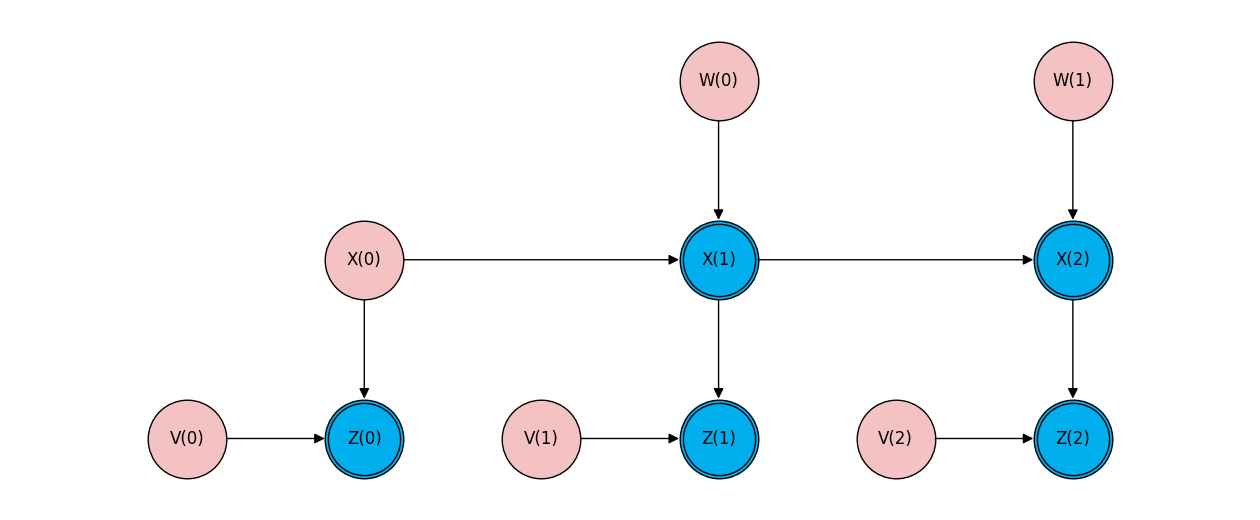

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import FancyArrowPatch


def create_fixed_graph():
    G = nx.DiGraph()

    G.add_node("V(0)", pos=(0, 0))
    G.add_node("Z(0)", pos=(1, 0))
    G.add_node("X(0)", pos=(1, 1))

    G.add_node("V(1)", pos=(2, 0))
    G.add_node("Z(1)", pos=(3, 0))
    G.add_node("X(1)", pos=(3, 1))

    G.add_node("V(2)", pos=(4, 0))
    G.add_node("Z(2)", pos=(5, 0))
    G.add_node("X(2)", pos=(5, 1))

    G.add_node("W(0)", pos=(3, 2))
    G.add_node("W(1)", pos=(5, 2))

    G.add_edge("V(0)", "Z(0)")
    G.add_edge("X(0)", "Z(0)")
    G.add_edge("V(1)", "Z(1)")
    G.add_edge("X(1)", "Z(1)")
    G.add_edge("V(2)", "Z(2)")
    G.add_edge("X(2)", "Z(2)")
    G.add_edge("X(0)", "X(1)")
    G.add_edge("X(1)", "X(2)")
    G.add_edge("W(0)", "X(1)")
    G.add_edge("W(1)", "X(2)")

    return G


def adjust_edge_coords(pos, source, target, node_radius):
    sx, sy = pos[source]
    tx, ty = pos[target]
    dx, dy = tx - sx, ty - sy
    dist = (dx**2 + dy**2) ** 0.5
    if dist == 0:
        return (sx, sy), (tx, ty)
    nx_dir = dx / dist
    ny_dir = dy / dist
    start = (sx + nx_dir * node_radius, sy + ny_dir * node_radius)
    end = (tx - nx_dir * node_radius, ty - ny_dir * node_radius)
    return start, end


def draw_fixed_graph(G):
    pos = nx.get_node_attributes(G, "pos")
    fig, ax = plt.subplots(figsize=(16, 6.5))

    orange_nodes = ["V(0)", "V(1)", "V(2)", "W(0)", "W(1)", "X(0)"]
    blue_nodes = ["Z(0)", "Z(1)", "Z(2)", "X(1)", "X(2)"]

    orange = nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=orange_nodes,
        node_color="#f4c2c2",
        node_size=3200,
        edgecolors="black",
    )
    orange.set_zorder(1)

    blue_outer = nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=blue_nodes,
        node_color="#00afee",
        node_size=3200,
        edgecolors="black",
        linewidths=1,
    )
    blue_outer.set_zorder(1)

    blue_inner = nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=blue_nodes,
        node_color="#00afee",
        node_size=2700,
        edgecolors="black",
        linewidths=1,
    )
    blue_inner.set_zorder(2)

    labels = nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif")
    for label in labels.values():
        label.set_zorder(3)

    node_radius = 0.2075
    for source, target in G.edges():
        start, end = adjust_edge_coords(pos, source, target, node_radius)
        arrow = FancyArrowPatch(
            start, end, arrowstyle="-|>", mutation_scale=15, color="black", zorder=4
        )
        ax.add_patch(arrow)

    margin_limit = 0.2

    xs = [p[0] for p in pos.values()]
    ys = [p[1] for p in pos.values()]
    x_margin = (max(xs) - min(xs)) * margin_limit
    y_margin = (max(ys) - min(ys)) * margin_limit
    ax.set_xlim(min(xs) - x_margin, max(xs) + x_margin)
    ax.set_ylim(min(ys) - y_margin, max(ys) + y_margin)

    ax.set_axis_off()
    plt.show()


G = create_fixed_graph()
draw_fixed_graph(G)